# Prediction of creditworthiness for credit card issuance

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings

# Set display options
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_style("whitegrid")

# Define color schemes for consistency
TARGET_COLORS = ['#2ecc71', '#e74c3c']  # [0: no default, 1: default]
CATEGORICAL_PALETTE = 'Set2'
CONTINUOUS_PALETTE = 'viridis'

# Define feature groups for reuse
NUMERIC_FEATURES = ['AMT_INCOME_TOTAL', 'AGE', 'EMPLOYMENT_YEARS', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']
CATEGORICAL_FEATURES = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
                       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
                       'OCCUPATION_TYPE']  # Will be removed after initial analysis

# Function for unified figure creation
def create_figure(nrows=1, ncols=1, figsize=(12, 6)):
    """Create a figure with consistent styling."""
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    return fig, axes

## Step 1: Data Import and Initial Analysis

In this first step, we will:
1. Import the required libraries for data analysis and visualization
2. Load the credit scoring dataset
3. Perform initial data exploration to understand:
   - Dataset dimensions
   - Data types of each column
   - Missing values
   - Basic statistical descriptions
   
This initial analysis will help us understand the data quality and guide our next steps in the data cleaning process.

In [36]:
# Helper functions for data preprocessing
def load_and_preprocess_data(file_path):
    """Load and perform initial preprocessing of the credit scoring data."""
    # Read data
    df = pd.read_csv(file_path)
    
    # Convert days to years
    df['EMPLOYMENT_YEARS'] = df['DAYS_EMPLOYED'] / 365  # Preserve original sign
    df['AGE'] = -df['DAYS_BIRTH'] / 365
    
    # Drop original days columns
    df = df.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1)
    
    return df

def analyze_missing_values(df):
    """Analyze missing values in the dataset."""
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_info = pd.DataFrame({
        'Missing Values': missing,
        'Missing Percentage': missing_pct
    }).sort_values('Missing Percentage', ascending=False)
    return missing_info[missing_info['Missing Values'] > 0]

def detect_outliers(df, feature):
    """Detect outliers using IQR method and return bounds."""
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

# Load and preprocess the data
df = load_and_preprocess_data('credit_scoring.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFeature Data Types:")
print(df.dtypes)

# Display missing values analysis
missing_info = analyze_missing_values(df)
if not missing_info.empty:
    print("\nMissing Values Analysis:")
    print(missing_info)
    print("\nTotal rows with missing values:", df.isnull().any(axis=1).sum())
    print(f"Percentage of rows with missing values: {(df.isnull().any(axis=1).sum() / len(df)) * 100:.2f}%")
else:
    print("\nNo missing values found in the dataset.")

Dataset Shape: (338427, 19)

Feature Data Types:
ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
FLAG_MOBIL             float64
FLAG_WORK_PHONE        float64
FLAG_PHONE             float64
FLAG_EMAIL             float64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
TARGET                   int64
EMPLOYMENT_YEARS       float64
AGE                    float64
dtype: object

Missing Values Analysis:
                    Missing Values  Missing Percentage
OCCUPATION_TYPE             103342           30.535980
NAME_HOUSING_TYPE                1            0.000295
NAME_FAMILY_STATUS               1            0.000295
AGE                              1            0.000295
EMPLOYMENT_YEARS                 1            0

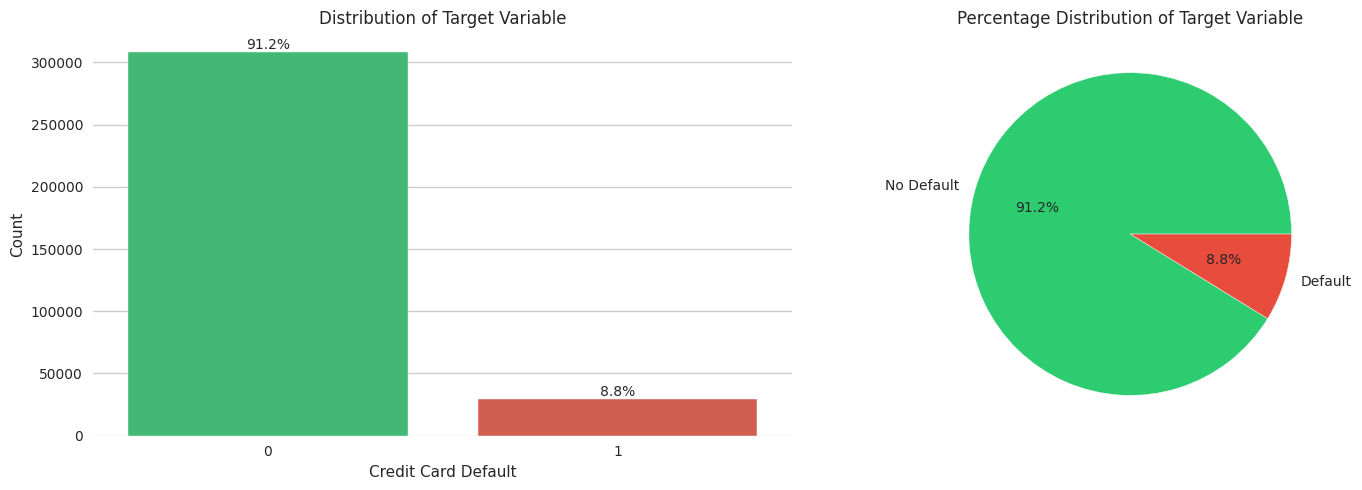

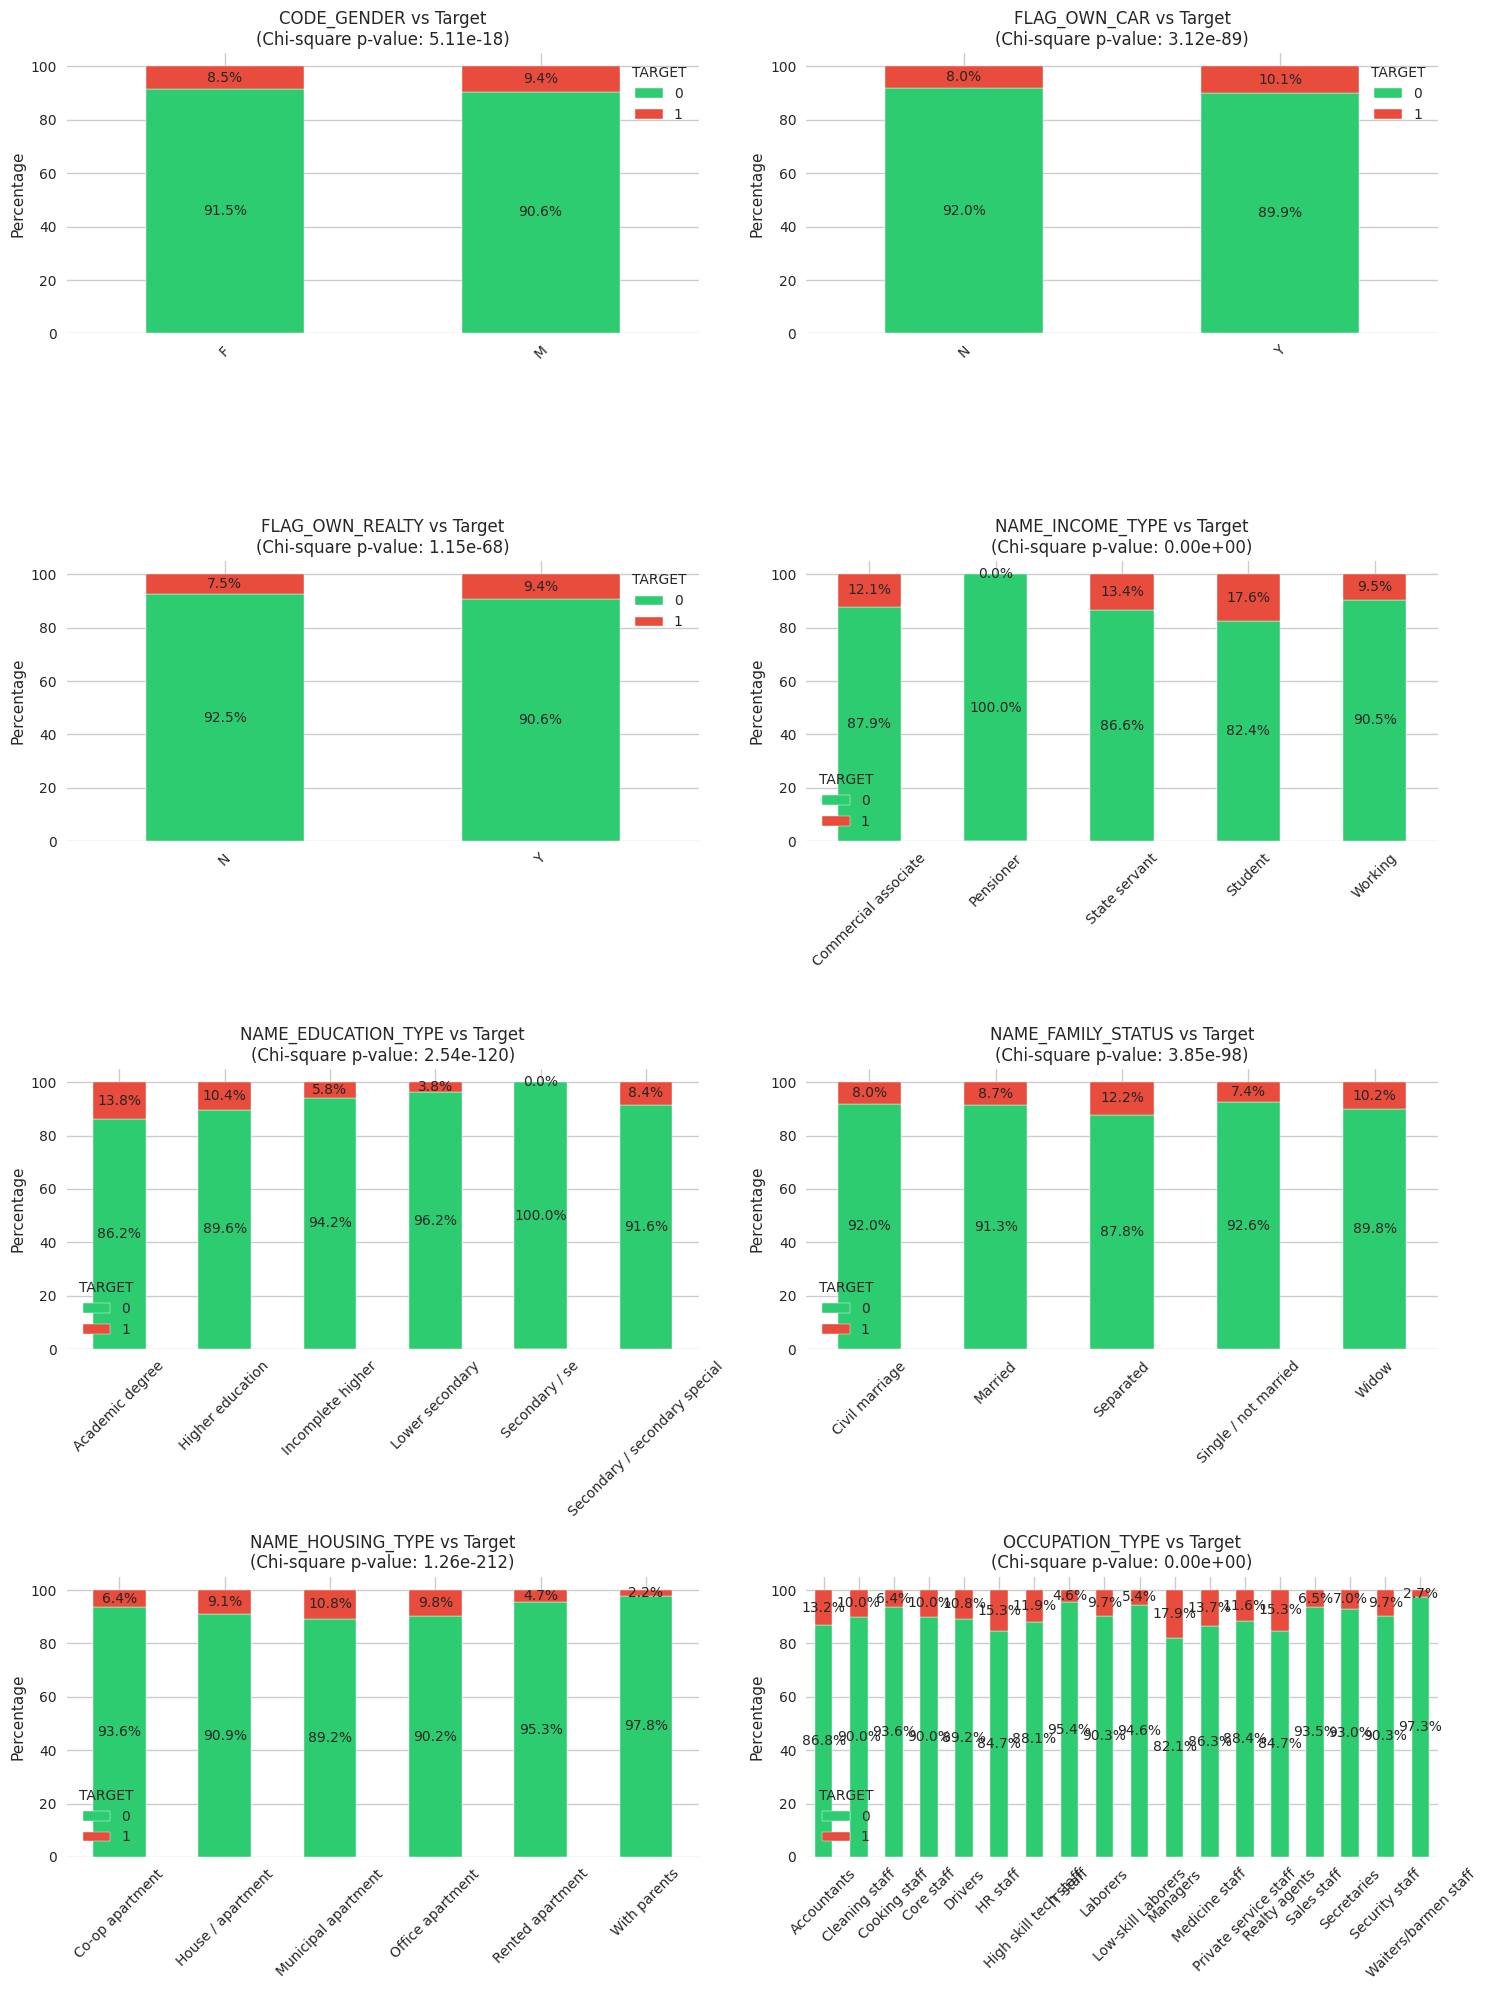

In [37]:
# Target Variable Analysis
def analyze_target_distribution(df, target_col='TARGET'):
    """Analyze and visualize target variable distribution."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Count plot
    target_counts = df[target_col].value_counts()
    sns.barplot(x=target_counts.index, y=target_counts.values, 
                palette=TARGET_COLORS, ax=ax1)
    ax1.set_title('Distribution of Target Variable')
    ax1.set_xlabel('Credit Card Default')
    ax1.set_ylabel('Count')
    
    # Add percentage labels
    total = len(df)
    for i, v in enumerate(target_counts.values):
        percentage = v / total * 100
        ax1.text(i, v, f'{percentage:.1f}%', 
                horizontalalignment='center', 
                verticalalignment='bottom')
    
    # Pie chart
    target_pct = target_counts / len(df) * 100
    ax2.pie(target_pct, labels=['No Default', 'Default'], 
            autopct='%1.1f%%', colors=TARGET_COLORS)
    ax2.set_title('Percentage Distribution of Target Variable')
    
    plt.tight_layout()
    return target_counts, target_pct

def analyze_categorical_vs_target(df, cat_features, target_col='TARGET'):
    """Analyze relationship between categorical features and target variable."""
    n_features = len(cat_features)
    n_cols = 2
    n_rows = (n_features + 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()
    
    for idx, feature in enumerate(cat_features):
        # Create contingency table
        cross_tab = pd.crosstab(df[feature], df[target_col], normalize='index') * 100
        
        # Stacked bar plot
        cross_tab.plot(kind='bar', stacked=True, ax=axes[idx],
                      color=TARGET_COLORS)
        
        # Chi-square test
        contingency = pd.crosstab(df[feature], df[target_col])
        chi2, p = chi2_contingency(contingency)[:2]
        
        axes[idx].set_title(f'{feature} vs Target\n(Chi-square p-value: {p:.2e})')
        axes[idx].set_xlabel('')
        axes[idx].set_ylabel('Percentage')
        axes[idx].tick_params(axis='x', rotation=45)
        
        # Add percentage labels
        for i in range(len(cross_tab)):
            cum_sum = 0
            for j in range(len(cross_tab.columns)):
                value = cross_tab.iloc[i, j]
                axes[idx].text(i, cum_sum + value/2, 
                             f'{value:.1f}%', 
                             ha='center', va='center')
                cum_sum += value
    
    # Remove empty subplots if any
    for idx in range(len(cat_features), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    return None

# Analyze target variable distribution
target_counts, target_pct = analyze_target_distribution(df)

# Analyze categorical features vs target
analyze_categorical_vs_target(df, CATEGORICAL_FEATURES)

Outlier Summary:

AMT_INCOME_TOTAL:
  Number of outliers: 14027
  Percentage of outliers: 4.14%
  Bounds: [-34737.36, 381175.46]

AGE:
  Number of outliers: 0
  Percentage of outliers: 0.00%
  Bounds: [5.73, 81.90]

CNT_CHILDREN:
  Number of outliers: 4757
  Percentage of outliers: 1.41%
  Bounds: [-1.50, 2.50]

CNT_FAM_MEMBERS:
  Number of outliers: 4440
  Percentage of outliers: 1.31%
  Bounds: [0.50, 4.50]


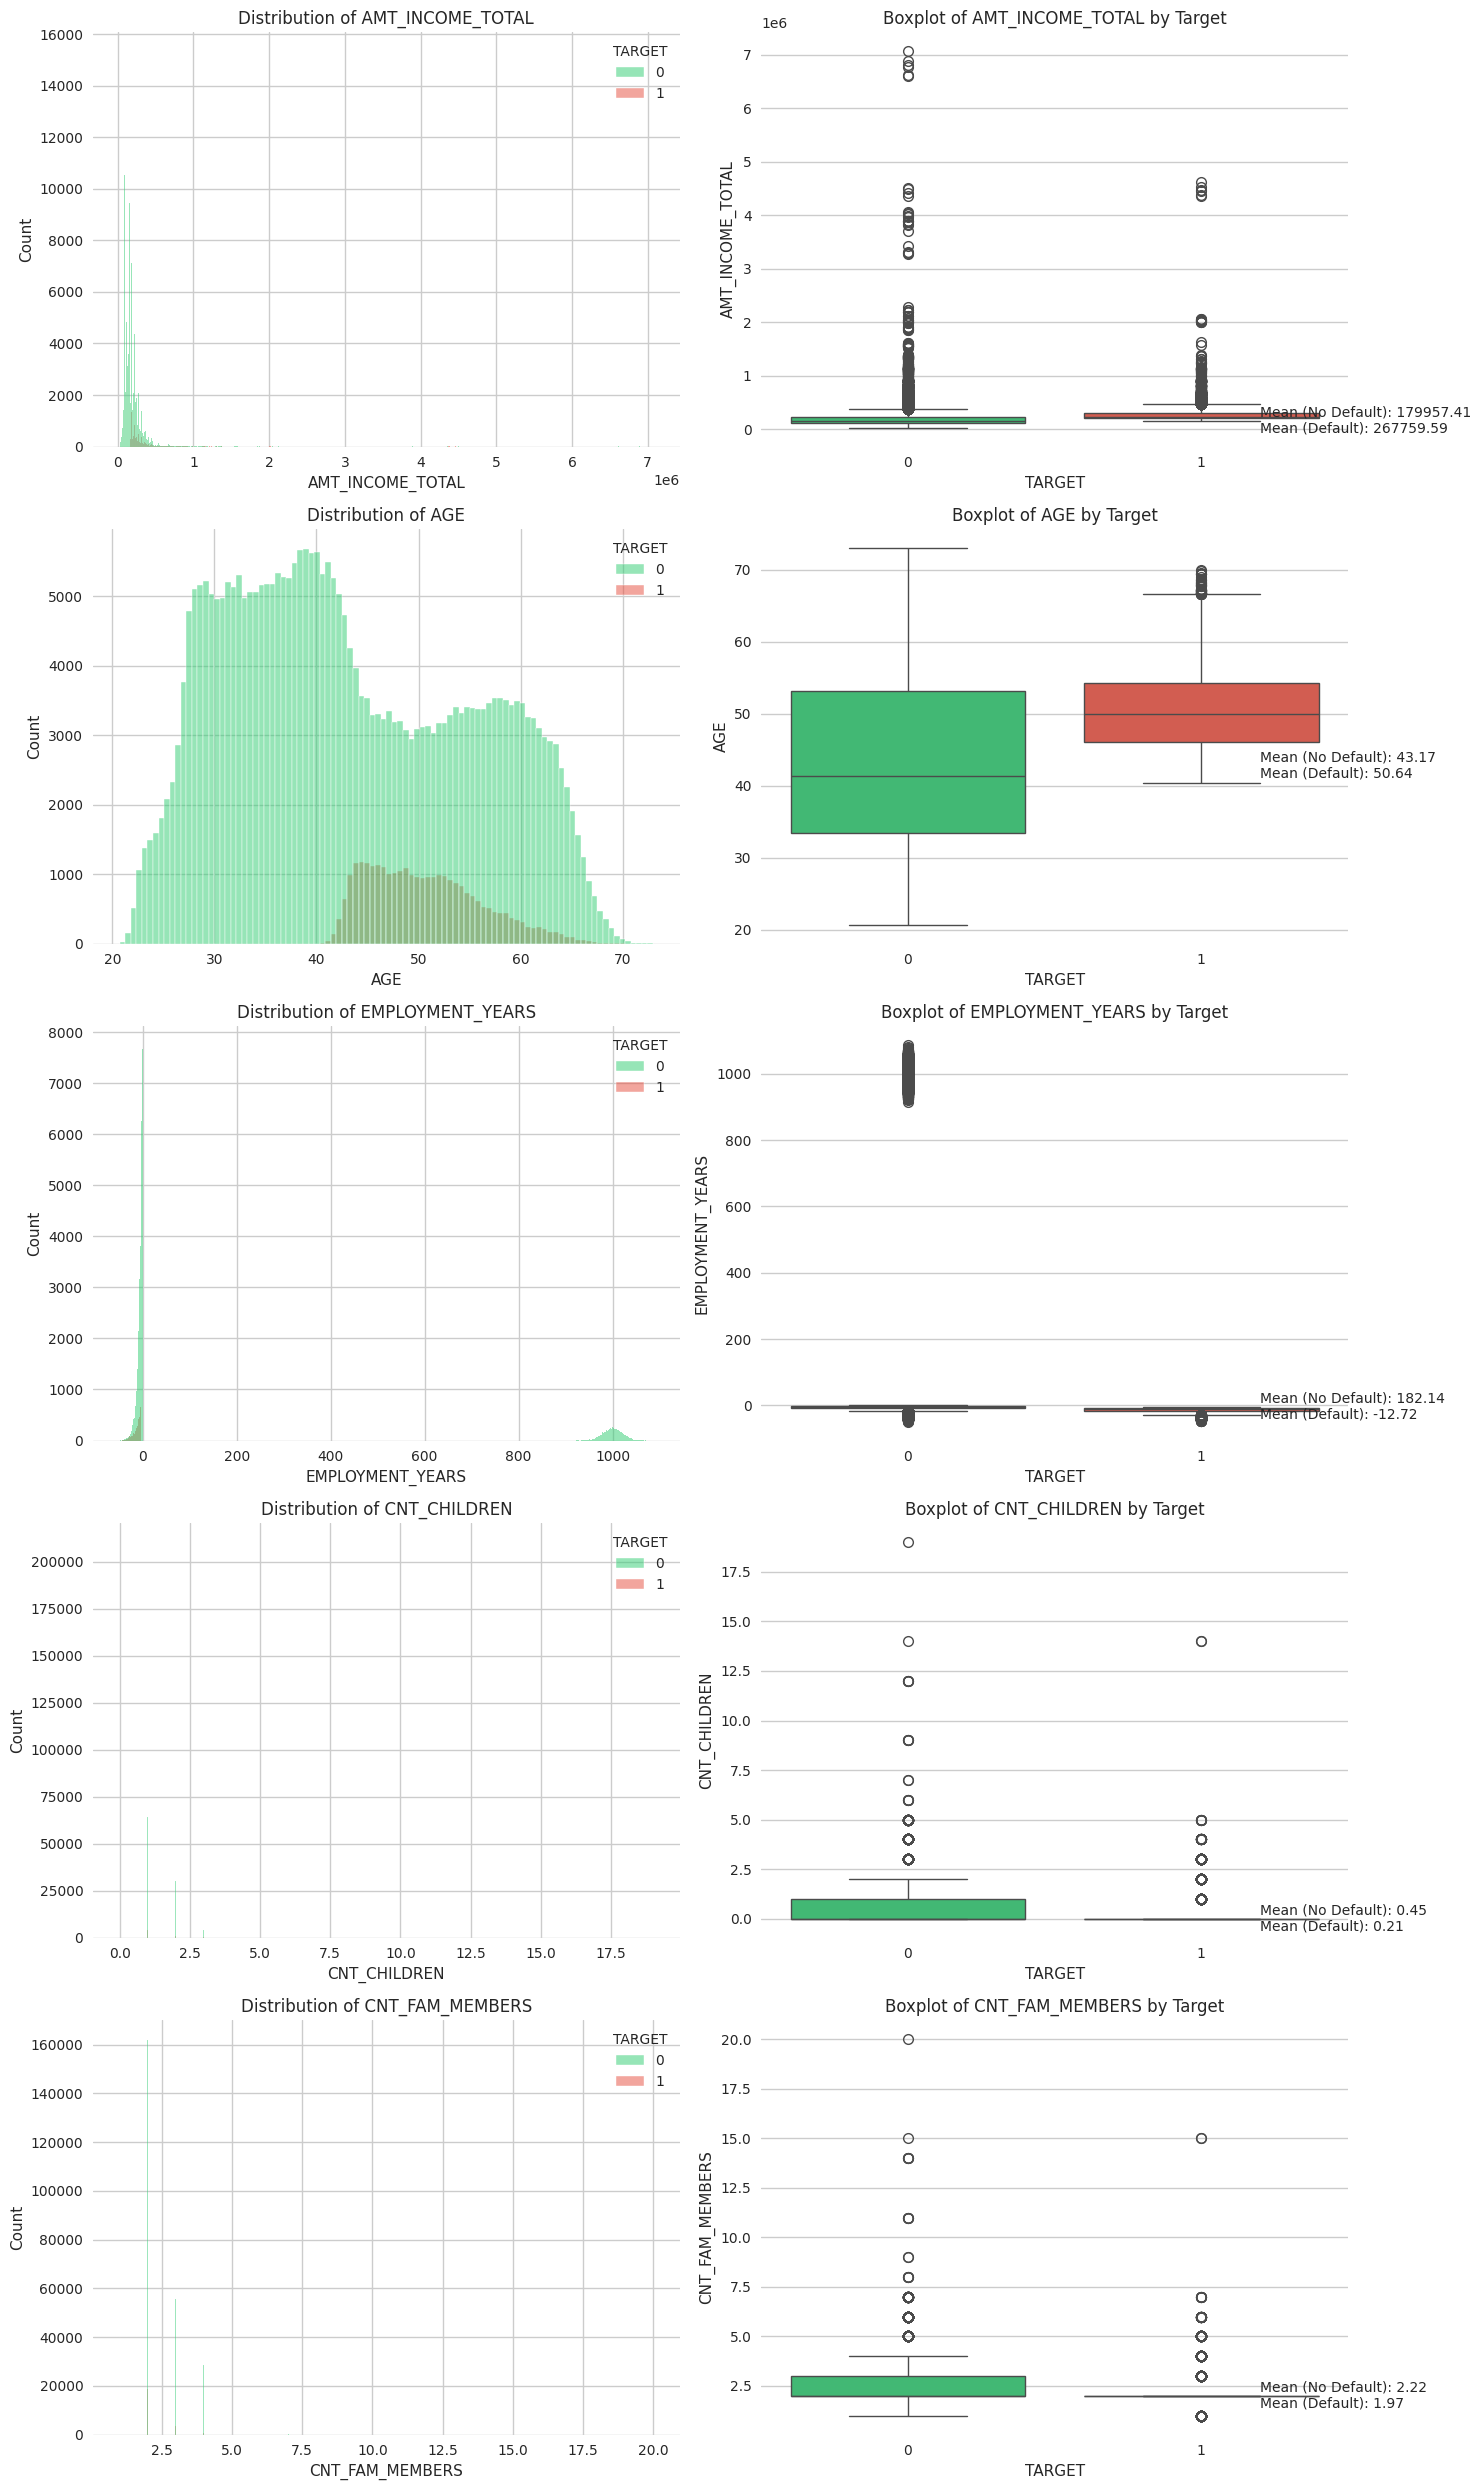

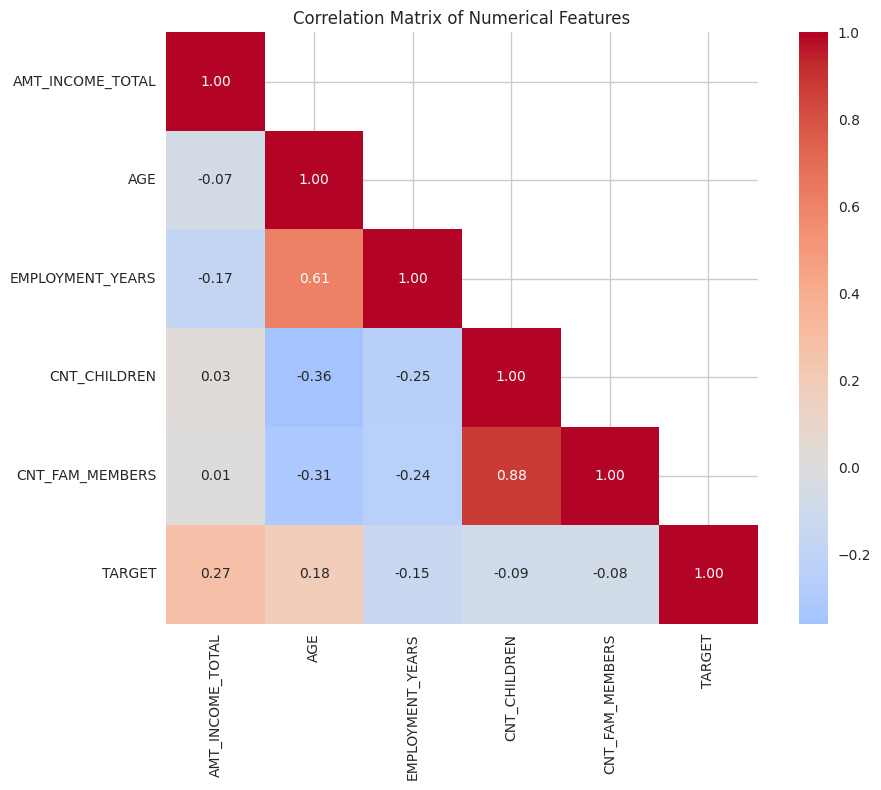

In [38]:
# Numerical Features Analysis
def analyze_numerical_features(df, numeric_features):
    """Analyze numerical features with histograms and boxplots."""
    n_features = len(numeric_features)
    fig, axes = plt.subplots(n_features, 2, figsize=(15, 5*n_features))
    
    for idx, feature in enumerate(numeric_features):
        # Histogram with KDE
        sns.histplot(data=df, x=feature, hue='TARGET', 
                    multiple="layer", palette=TARGET_COLORS,
                    alpha=0.5, ax=axes[idx, 0])
        axes[idx, 0].set_title(f'Distribution of {feature}')
        
        # Boxplot
        sns.boxplot(data=df, y=feature, x='TARGET',
                   palette=TARGET_COLORS, ax=axes[idx, 1])
        axes[idx, 1].set_title(f'Boxplot of {feature} by Target')
        
        # Add basic statistics
        stats = df.groupby('TARGET')[feature].describe()
        stats_text = (f"Mean (No Default): {stats.loc[0, 'mean']:.2f}\n"
                     f"Mean (Default): {stats.loc[1, 'mean']:.2f}")
        axes[idx, 1].text(1.2, df[feature].median(), stats_text,
                         verticalalignment='center')
    
    plt.tight_layout()
    return None

def detect_and_handle_outliers(df, numeric_features):
    """Detect and handle outliers in numerical features."""
    df_cleaned = df.copy()
    outlier_summary = {}
    
    for feature in numeric_features:
        # Special handling for EMPLOYMENT_YEARS (preserve sign)
        if feature == 'EMPLOYMENT_YEARS':
            continue
            
        # Detect outliers
        lower_bound, upper_bound = detect_outliers(df, feature)
        mask = (df[feature] < lower_bound) | (df[feature] > upper_bound)
        outliers = mask.sum()
        
        # Store outlier information
        outlier_summary[feature] = {
            'outliers_count': outliers,
            'outliers_percentage': (outliers/len(df))*100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }
        
        # Handle outliers by clipping
        df_cleaned[feature] = df_cleaned[feature].clip(lower_bound, upper_bound)
    
    # Print outlier summary
    print("Outlier Summary:")
    for feature, info in outlier_summary.items():
        print(f"\n{feature}:")
        print(f"  Number of outliers: {info['outliers_count']}")
        print(f"  Percentage of outliers: {info['outliers_percentage']:.2f}%")
        print(f"  Bounds: [{info['lower_bound']:.2f}, {info['upper_bound']:.2f}]")
    
    return df_cleaned, outlier_summary

# Analyze numerical features
analyze_numerical_features(df, NUMERIC_FEATURES)

# Detect and handle outliers
df_cleaned, outlier_summary = detect_and_handle_outliers(df, NUMERIC_FEATURES)

# Create correlation matrix visualization
def plot_correlation_matrix(df, features):
    """Plot correlation matrix for selected features."""
    correlation_matrix = df[features + ['TARGET']].corr()
    
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(correlation_matrix), k=1)
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
                center=0, fmt='.2f', square=True)
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    return correlation_matrix

# Plot correlation matrix
correlation_matrix = plot_correlation_matrix(df_cleaned, NUMERIC_FEATURES)

## Final Data Cleaning

After the initial analysis, we will proceed with:
1. Removing the OCCUPATION_TYPE column due to high percentage of missing values
2. Applying business rules for data cleaning
3. Verifying cleaning results


Removing OCCUPATION_TYPE column
Missing values in OCCUPATION_TYPE: 103342 (30.54%)

Checking remaining missing values:


                    Missing Values  Missing Percentage
NAME_HOUSING_TYPE                1            0.000295
NAME_FAMILY_STATUS               1            0.000295
AGE                              1            0.000295
FLAG_PHONE                       1            0.000295
EMPLOYMENT_YEARS                 1            0.000295
CNT_FAM_MEMBERS                  1            0.000295
FLAG_EMAIL                       1            0.000295
FLAG_MOBIL                       1            0.000295
FLAG_WORK_PHONE                  1            0.000295

Total rows before removing missing values: 338427
Rows removed due to missing values: 1
Percentage of rows removed: 0.00%

Dataset Info after cleaning:
Shape before: (338427, 19)
Shape after: (338426, 18)

Numerical features statistics after cleaning:

AMT_INCOME_TOTAL:
Before:
count    3.384270e+05
mean     1.876685e+05
std      1.107863e+05
min      2.554898e+04
25%      1.212299e+05
50%      1.628553e+05
75%      2.252082e+05
max      7.07101

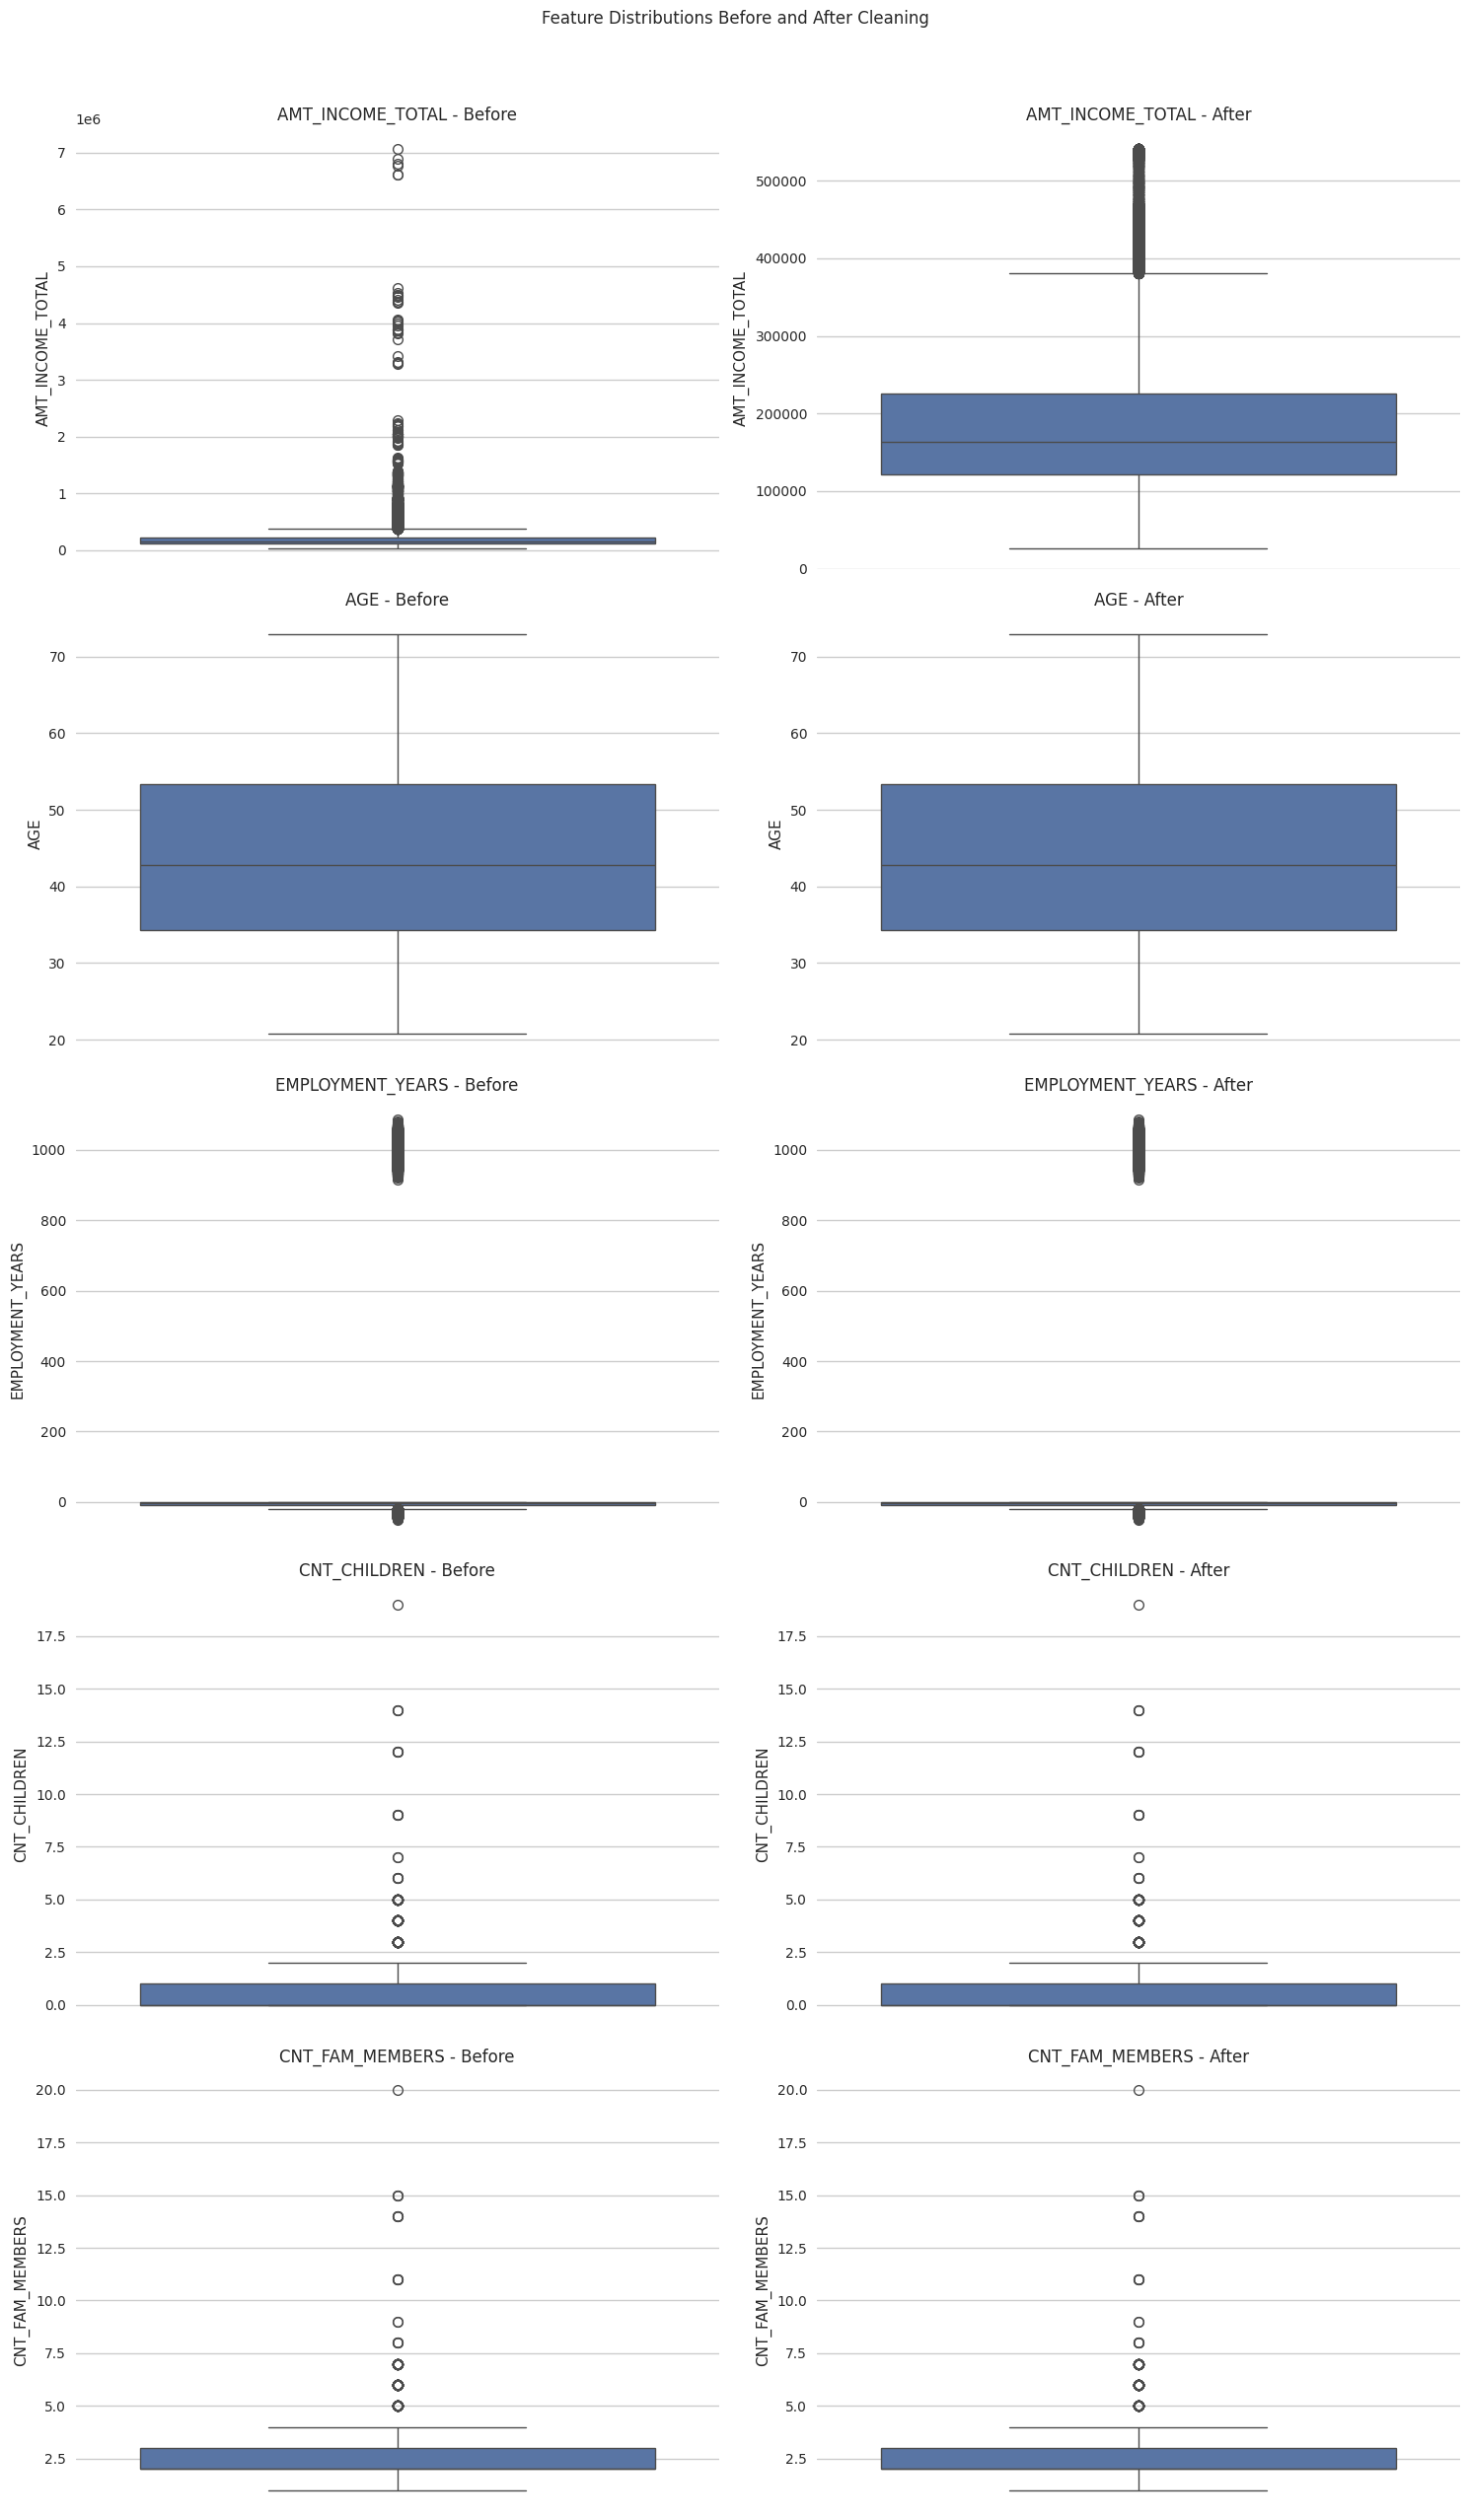


No missing values remain in the cleaned dataset


In [39]:
# Function for final data cleaning
def clean_data(df):
    """Clean data applying business rules and remove missing values"""
    df_cleaned = df.copy()
    
    # 1. Remove OCCUPATION_TYPE column first
    print("\nRemoving OCCUPATION_TYPE column")
    print(f"Missing values in OCCUPATION_TYPE: {df_cleaned['OCCUPATION_TYPE'].isnull().sum()} "
          f"({df_cleaned['OCCUPATION_TYPE'].isnull().mean()*100:.2f}%)")
    df_cleaned = df_cleaned.drop('OCCUPATION_TYPE', axis=1)
    
    # 2. Handle remaining missing values
    print("\nChecking remaining missing values:")
    remaining_missing = analyze_missing_values(df_cleaned)
    print(remaining_missing)
    print(f"\nTotal rows before removing missing values: {len(df_cleaned)}")
    
    # Remove rows with remaining missing values
    df_cleaned = df_cleaned.dropna()
    print(f"Rows removed due to missing values: {len(df) - len(df_cleaned)}")
    print(f"Percentage of rows removed: {((len(df) - len(df_cleaned)) / len(df)) * 100:.2f}%")
    
    # 3. Age: clip to logical bounds
    df_cleaned['AGE'] = df_cleaned['AGE'].clip(18, 100)
    
    # 4. Income: remove extreme outliers
    income_upper = df_cleaned['AMT_INCOME_TOTAL'].quantile(0.99)
    df_cleaned['AMT_INCOME_TOTAL'] = df_cleaned['AMT_INCOME_TOTAL'].clip(0, income_upper)
    
    # 5. Family features: logical limits
    df_cleaned['CNT_CHILDREN'] = df_cleaned['CNT_CHILDREN'].clip(0, 20)
    df_cleaned['CNT_FAM_MEMBERS'] = df_cleaned['CNT_FAM_MEMBERS'].clip(1, 20)
    
    # 6. Ensure family members >= children + 1
    df_cleaned['CNT_FAM_MEMBERS'] = df_cleaned[['CNT_CHILDREN', 'CNT_FAM_MEMBERS']].apply(
        lambda x: max(x['CNT_FAM_MEMBERS'], x['CNT_CHILDREN'] + 1), axis=1
    )
    
    return df_cleaned

# Apply final cleaning
df_cleaned = clean_data(df)

# Update categorical features list
CATEGORICAL_FEATURES.remove('OCCUPATION_TYPE')

# Print cleaning results
print("\nDataset Info after cleaning:")
print("Shape before:", df.shape)
print("Shape after:", df_cleaned.shape)

print("\nNumerical features statistics after cleaning:")
for feature in NUMERIC_FEATURES:
    print(f"\n{feature}:")
    print("Before:")
    print(df[feature].describe())
    print("\nAfter:")
    print(df_cleaned[feature].describe())

# Visualize the effect of cleaning
fig, axes = plt.subplots(len(NUMERIC_FEATURES), 2, figsize=(15, 5*len(NUMERIC_FEATURES)))
fig.suptitle('Feature Distributions Before and After Cleaning', y=1.02)

for idx, feature in enumerate(NUMERIC_FEATURES):
    # Before cleaning
    sns.boxplot(data=df, y=feature, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{feature} - Before')
    
    # After cleaning
    sns.boxplot(data=df_cleaned, y=feature, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{feature} - After')

plt.tight_layout()
plt.show()

# Verify no missing values remain
missing_after = analyze_missing_values(df_cleaned)
if missing_after.empty:
    print("\nNo missing values remain in the cleaned dataset")
else:
    print("\nWarning: Some missing values remain:")
    print(missing_after)


Statistiche dopo la pulizia:

AMT_INCOME_TOTAL:
count    338427.000000
mean     185531.982462
std       91002.350433
min       25548.980000
25%      121229.950000
50%      162855.260000
75%      225208.155000
max      541509.012400
Name: AMT_INCOME_TOTAL, dtype: float64

AGE:
count    338426.000000
mean         43.830720
std          11.487914
min          20.728767
25%          34.291096
50%          42.802740
75%          53.334247
max          72.975342
Name: AGE, dtype: float64

EMPLOYMENT_YEARS:
count    338426.000000
mean        165.026120
std         379.514858
min         -49.241096
25%          -8.536986
50%          -4.063014
75%          -1.035616
max        1086.295890
Name: EMPLOYMENT_YEARS, dtype: float64

CNT_CHILDREN:
count    338427.000000
mean          0.428934
std           0.727990
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64

CNT_FAM_MEMBERS:
count    338426.00

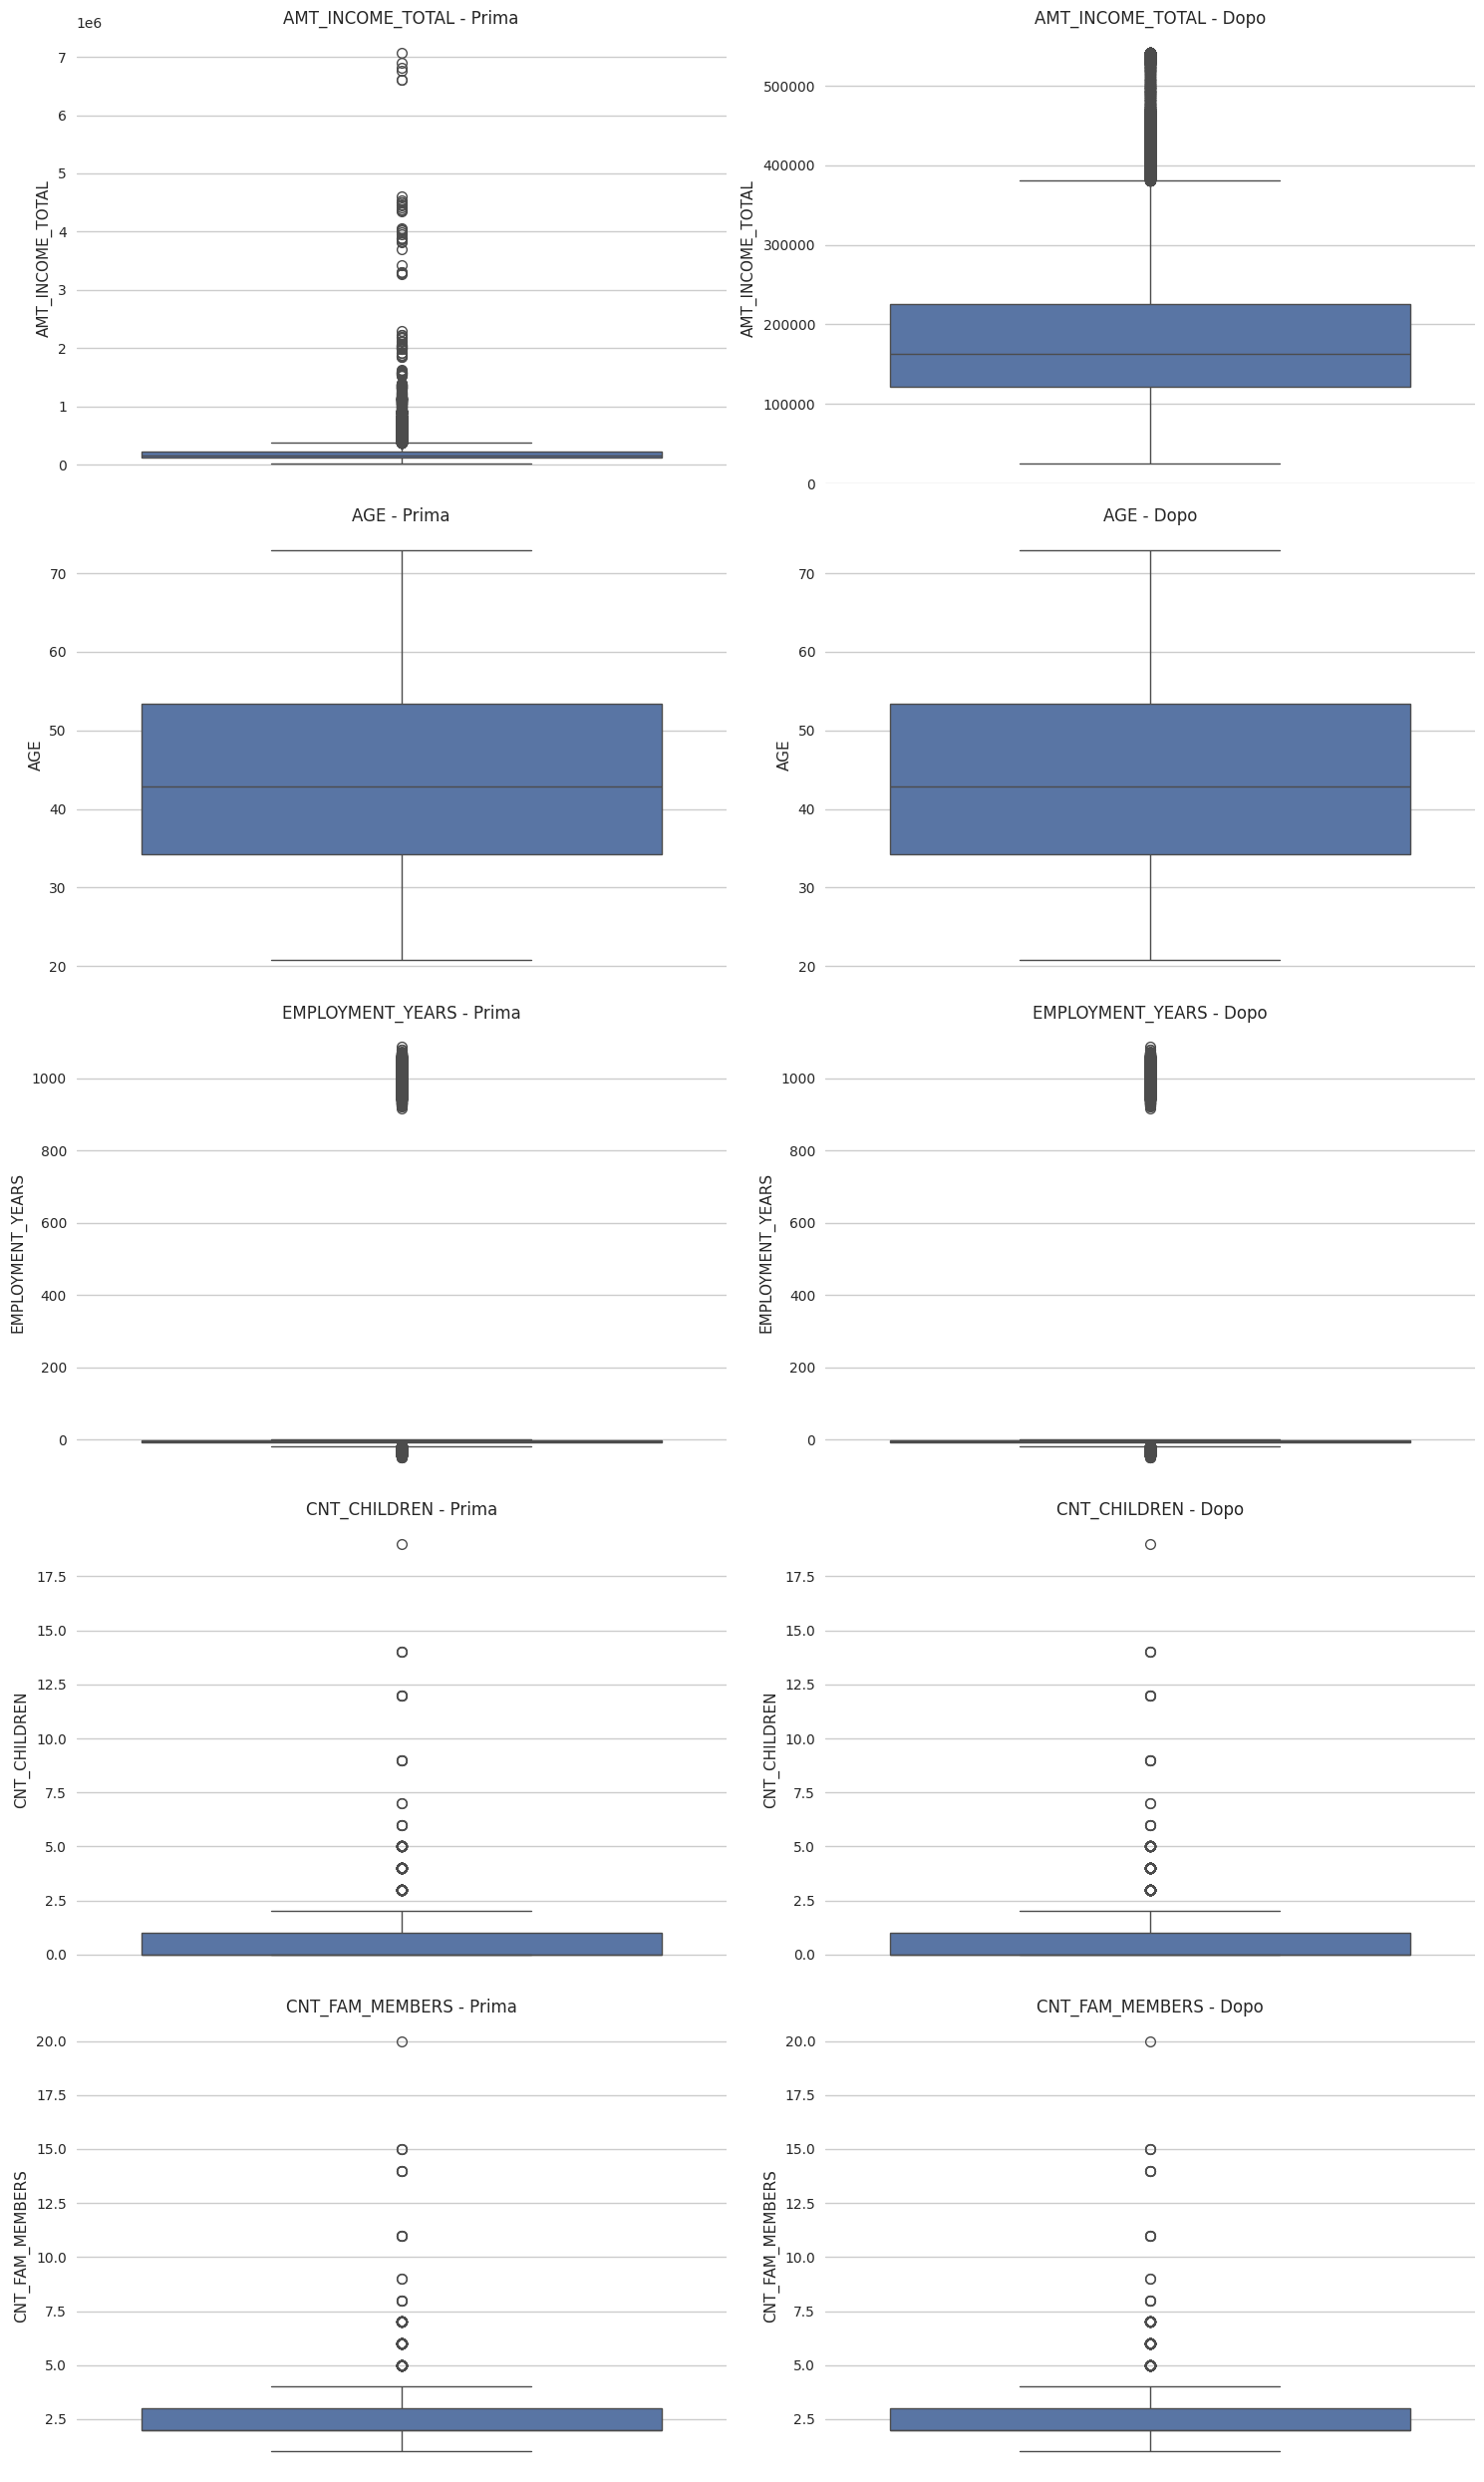

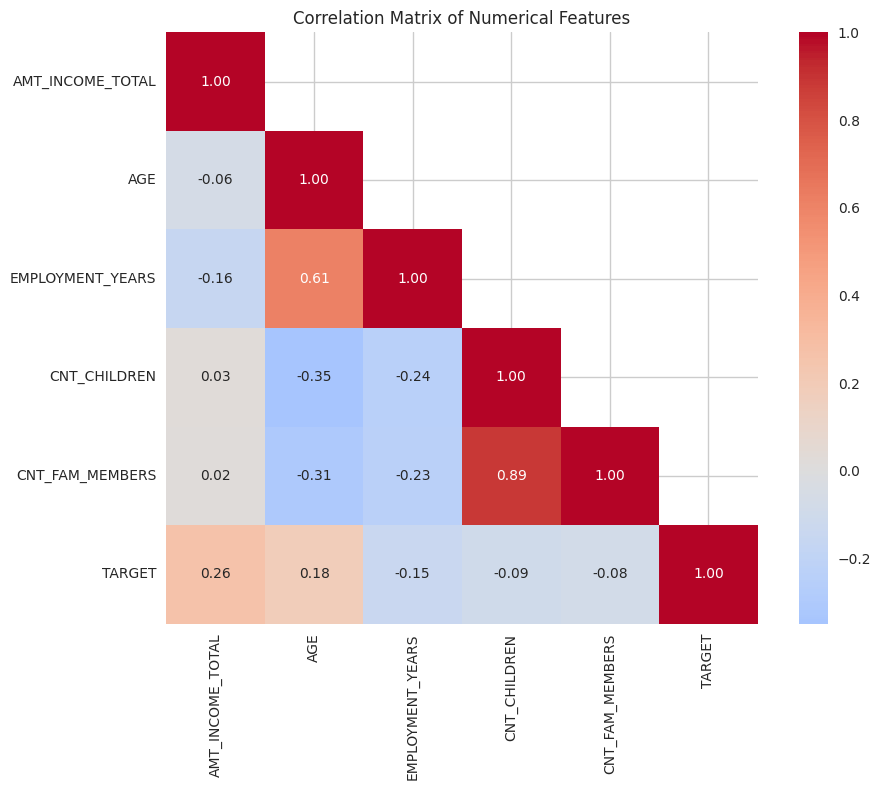

In [42]:
def clean_and_preprocess_data(df):
    """
    Funzione completa per la pulizia e il preprocessing dei dati
    """
    df_cleaned = df.copy()
    
    # 1. Gestione dell'età
    df_cleaned['AGE'] = df_cleaned['AGE'].clip(18, 100)
    
    # 2. Gestione del reddito
    income_upper = df_cleaned['AMT_INCOME_TOTAL'].quantile(0.99)
    df_cleaned['AMT_INCOME_TOTAL'] = df_cleaned['AMT_INCOME_TOTAL'].clip(0, income_upper)
    
    # 3. Gestione features familiari con limiti logici
    df_cleaned['CNT_CHILDREN'] = df_cleaned['CNT_CHILDREN'].clip(0, 20)  # Max 20 figli
    df_cleaned['CNT_FAM_MEMBERS'] = df_cleaned['CNT_FAM_MEMBERS'].clip(1, 20)  # Min 1 membro
    
    # 4. Verifica la coerenza tra CNT_CHILDREN e CNT_FAM_MEMBERS
    df_cleaned['CNT_FAM_MEMBERS'] = df_cleaned[['CNT_CHILDREN', 'CNT_FAM_MEMBERS']].apply(
        lambda x: max(x['CNT_FAM_MEMBERS'], x['CNT_CHILDREN'] + 1), axis=1
    )
    
    # Stampa statistiche dopo la pulizia
    print("\nStatistiche dopo la pulizia:")
    for feature in NUMERIC_FEATURES:
        print(f"\n{feature}:")
        print(df_cleaned[feature].describe())
    
    return df_cleaned

# Applica la pulizia completa
df_cleaned = clean_and_preprocess_data(df)

# Verifica le distribuzioni dopo la pulizia
fig, axes = plt.subplots(len(NUMERIC_FEATURES), 2, figsize=(15, 5*len(NUMERIC_FEATURES)))
for idx, feature in enumerate(NUMERIC_FEATURES):
    # Prima della pulizia
    sns.boxplot(data=df, y=feature, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{feature} - Prima')
    
    # Dopo la pulizia
    sns.boxplot(data=df_cleaned, y=feature, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{feature} - Dopo')

plt.tight_layout()
plt.show()

# Mostra le correlazioni dopo la pulizia
correlation_matrix = plot_correlation_matrix(df_cleaned, NUMERIC_FEATURES)

Default Rate by Employment Status:
Employed: 10.6%
Unemployed: 0.0%


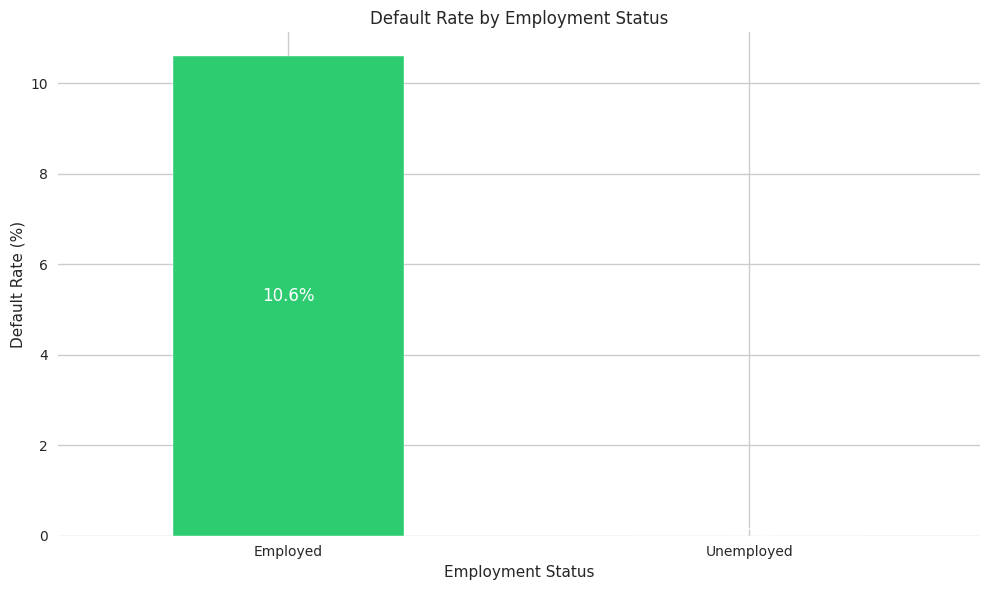

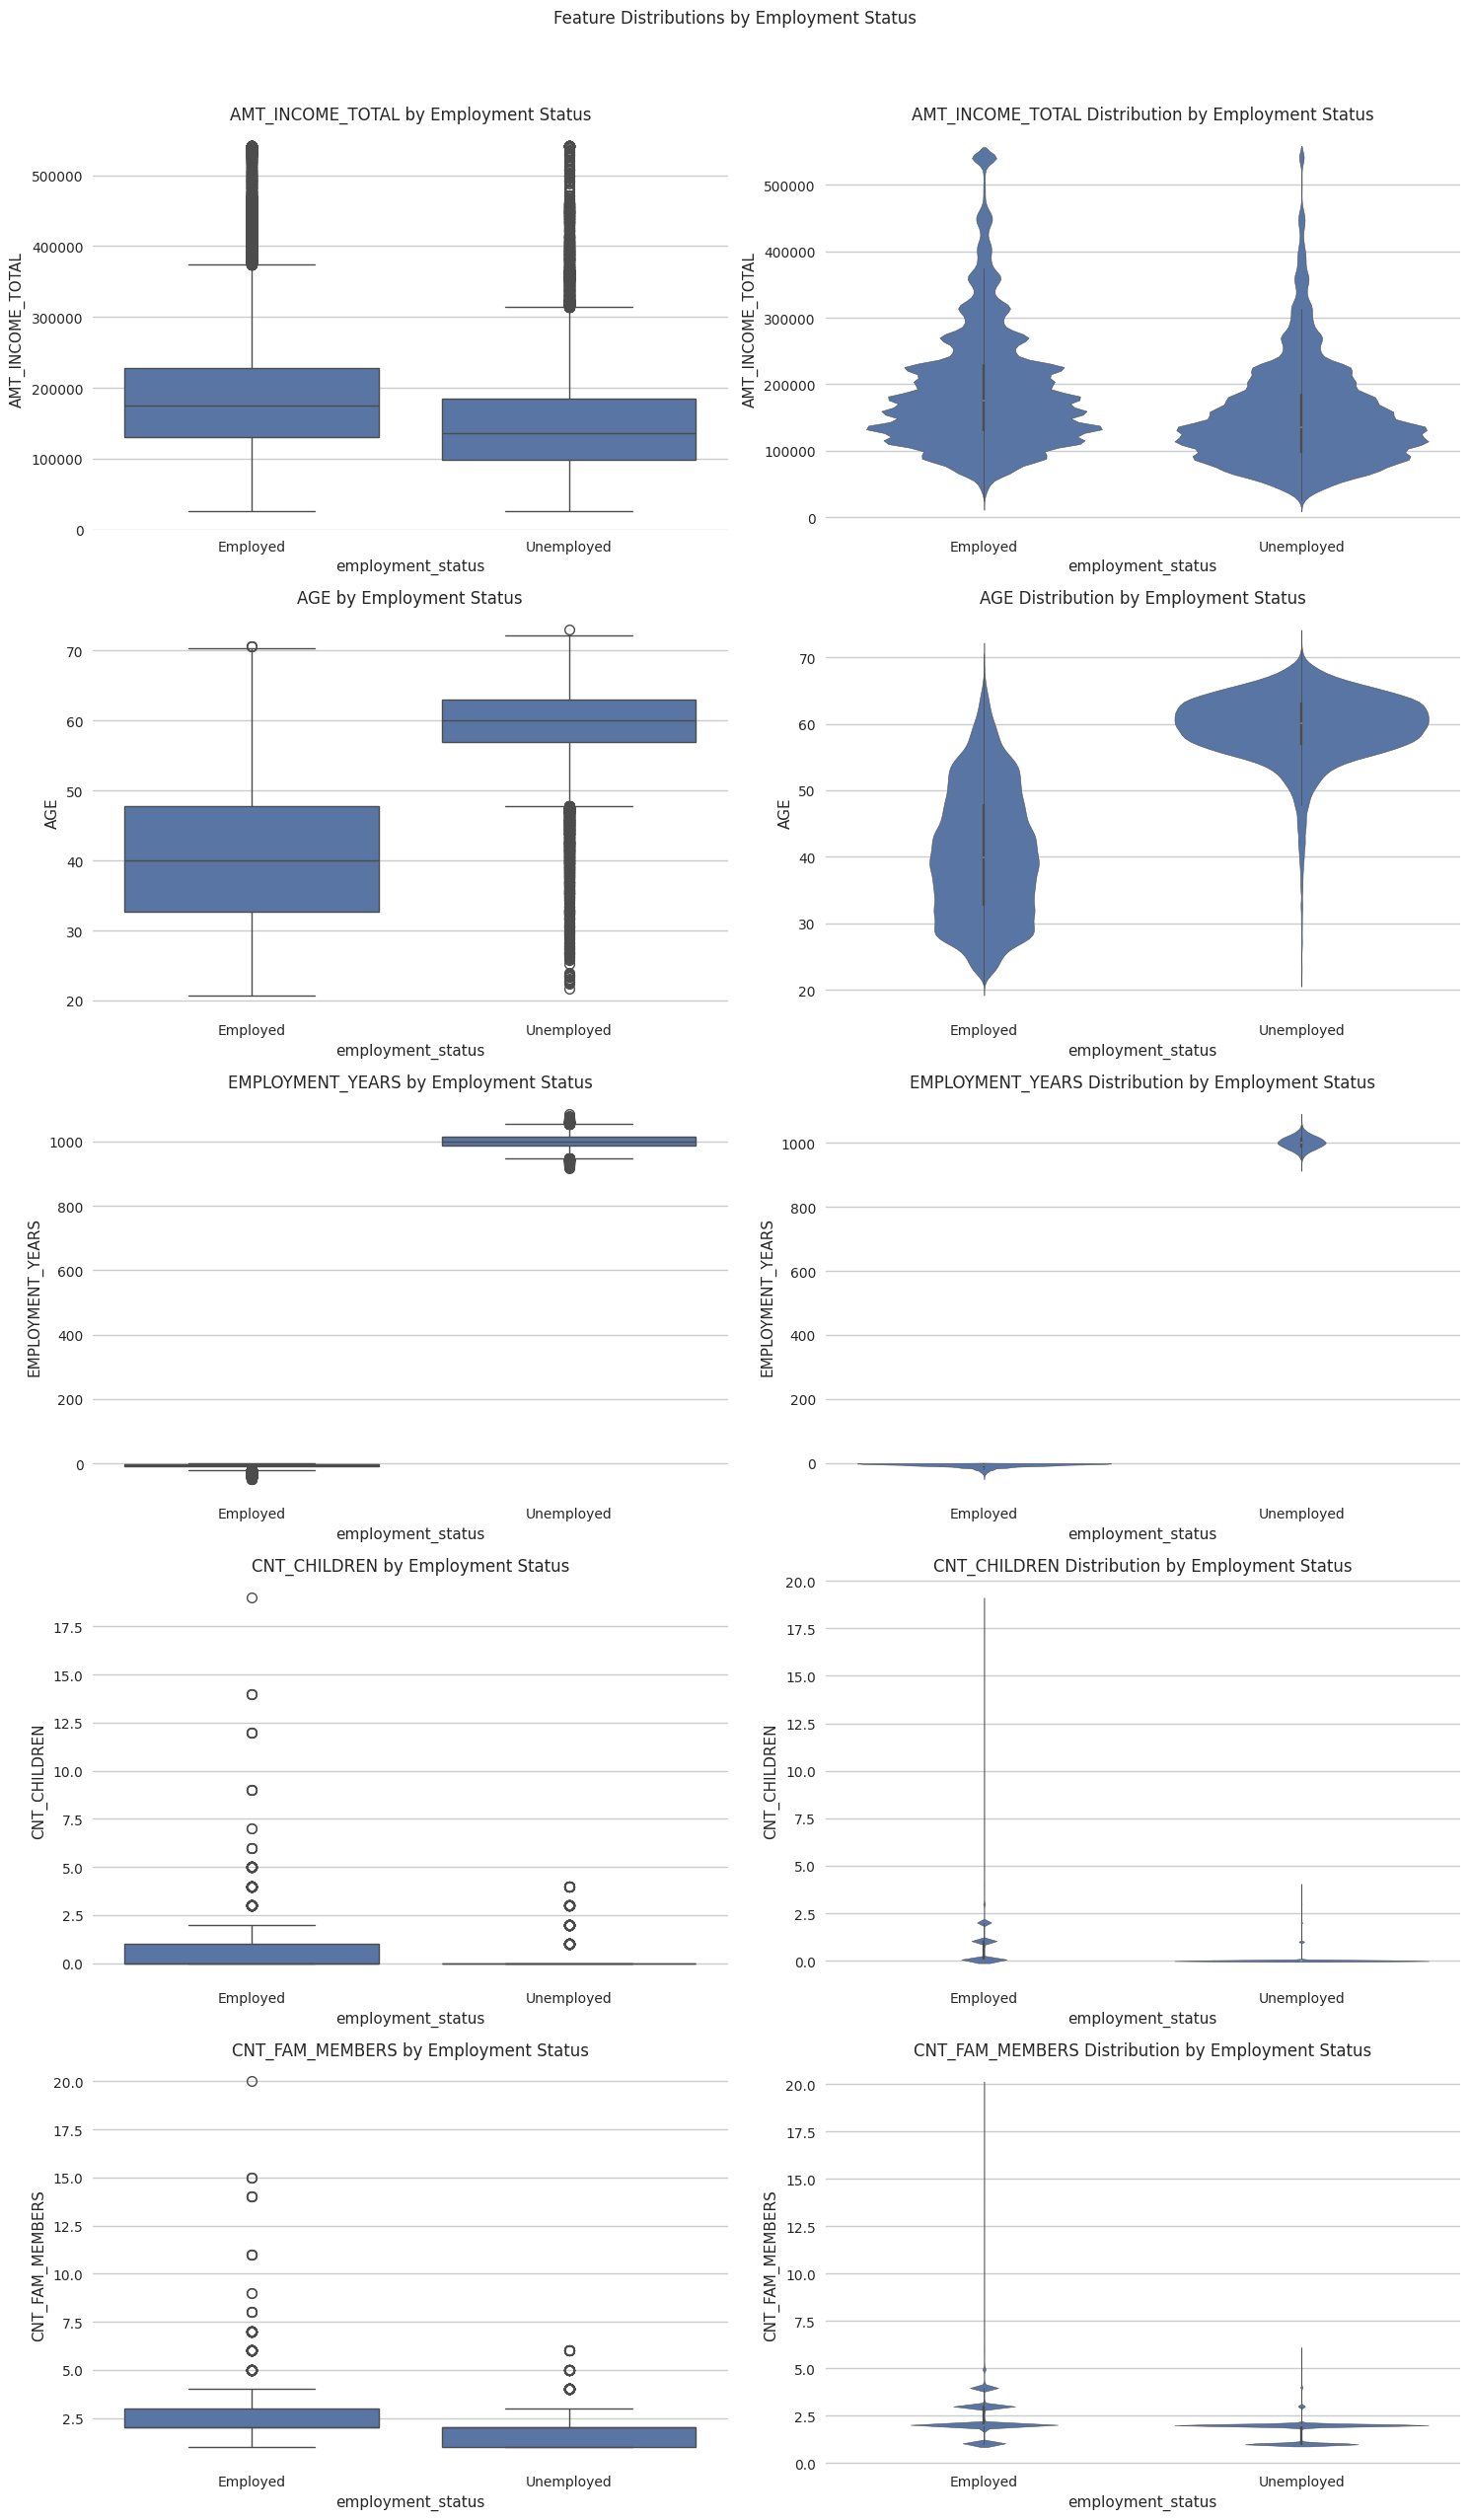

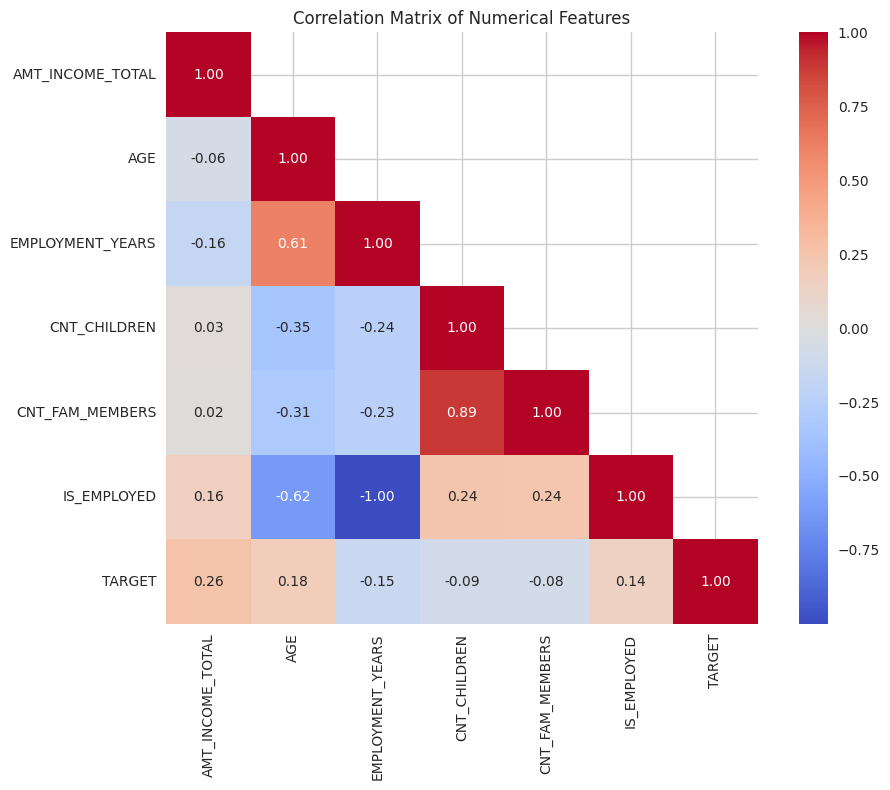

In [41]:
# Employment Status Analysis
def analyze_employment_status(df):
    """Analyze the relationship between employment status and default rate."""
    # Create employment status indicator
    df['employment_status'] = np.where(df['EMPLOYMENT_YEARS'] < 0, 'Employed', 'Unemployed')
    
    # Calculate default rates by employment status
    employment_default = df.groupby('employment_status')['TARGET'].mean() * 100
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    employment_default.plot(kind='bar', color=TARGET_COLORS)
    plt.title('Default Rate by Employment Status')
    plt.xlabel('Employment Status')
    plt.ylabel('Default Rate (%)')
    
    # Add percentage labels
    for i, rate in enumerate(employment_default):
        plt.text(i, rate/2, f'{rate:.1f}%', 
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=12,
                color='white')
    
    plt.xticks(rotation=0)
    plt.tight_layout()
    
    # Print statistics
    print("Default Rate by Employment Status:")
    for status, rate in employment_default.items():
        print(f"{status}: {rate:.1f}%")
    
    # Show distribution of numeric features by employment status
    fig, axes = plt.subplots(len(NUMERIC_FEATURES), 2, figsize=(15, 5*len(NUMERIC_FEATURES)))
    fig.suptitle('Feature Distributions by Employment Status', y=1.02)

    for idx, feature in enumerate(NUMERIC_FEATURES):
        # Boxplot
        sns.boxplot(data=df, x='employment_status', y=feature, ax=axes[idx, 0])
        axes[idx, 0].set_title(f'{feature} by Employment Status')
        
        # Violin plot
        sns.violinplot(data=df, x='employment_status', y=feature, ax=axes[idx, 1])
        axes[idx, 1].set_title(f'{feature} Distribution by Employment Status')

    plt.tight_layout()
    
    return employment_default

# Analyze employment status
employment_default_rates = analyze_employment_status(df_cleaned)

# Update correlation matrix with employment status
df_cleaned['IS_EMPLOYED'] = (df_cleaned['EMPLOYMENT_YEARS'] < 0).astype(int)
correlation_matrix = plot_correlation_matrix(df_cleaned, NUMERIC_FEATURES + ['IS_EMPLOYED'])

## Summary of Initial Analysis

### Key Findings
1. **Target Variable Distribution**
   - Imbalanced dataset with minority class (defaults)
   - Will need to consider class imbalance handling techniques

2. **Categorical Features**
   - Significant relationships between categorical variables and target
   - All categorical features show statistically significant associations (chi-square tests)

3. **Numerical Features**
   - Identified and handled outliers in key numerical features
   - EMPLOYMENT_YEARS preserved as is due to its special meaning
   - Clear differences in default rates between employed and unemployed groups

4. **Correlation Analysis**
   - Moderate correlations between some numerical features
   - Will need to consider feature selection/engineering

### Next Steps
1. **Feature Engineering**
   - Create interaction terms for correlated features
   - Bin numerical features where appropriate
   - Encode categorical variables (OneHotEncoder for low cardinality)

2. **Model Pipeline**
   - Create preprocessing pipeline with:
     - Standard scaling for numerical features
     - One-hot encoding for categorical features
     - SMOTE for handling class imbalance
   
3. **Model Selection**
   - Start with interpretable models (Logistic Regression, Decision Tree)
   - Progress to ensemble methods (Random Forest, XGBoost)
   - Implement cross-validation
   
4. **Evaluation**
   - Focus on relevant metrics for imbalanced classification:
     - ROC-AUC
     - Precision-Recall curve
     - F1-score
   - Consider business impact of false positives vs false negatives